In [2]:
from functools import reduce
from itertools import product
from typing import List

import igraph
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pynauty
import scipy.sparse as sp
from scipy.linalg import ishermitian
from sympy.combinatorics import Permutation, PermutationGroup

from qlinks.model.pxp_model_1d import fibonacci, PXPModel1D

np.set_printoptions(threshold=np.inf)
pd.set_option("display.max_rows", None)

In [3]:
def format_custom_index(index):
    return [f"({i}) {idx}" for i, idx in enumerate(index)]


def characteristic_matrix(partitions):
    n_total_elems = sum(len(part) for part in partitions)
    n_partitions = len(partitions)
    char_mat = np.zeros((n_total_elems, n_partitions), dtype=int)

    for j, partition in enumerate(partitions):
        for i in partition:
            char_mat[i][j] = 1
    return char_mat


def setup_igraph(nx_g, highlight: List[int] = None, highlight_color: List[str] = None):
    ig = igraph.Graph.from_networkx(nx_g)
    ig.vs["label"] = [str(i) for i in range(ig.vcount())]
    color = ["whitesmoke" for _ in range(ig.vcount())]
    if highlight is not None:
        for i, nodes in enumerate(highlight):
            for node in nodes:
                color[node] = highlight_color[i]
        ig.vs["color"] = color
    return ig

# archive this part

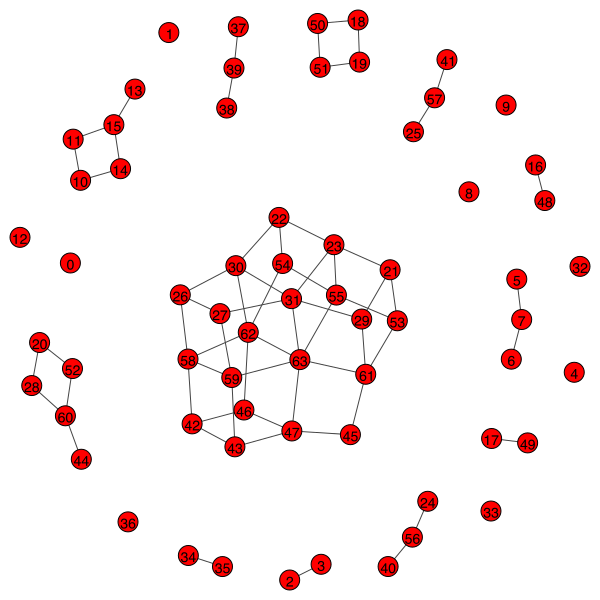

In [174]:
sz = sp.csr_array(np.array([[1, 0], [0, -1]]))
sx = sp.csr_array(np.array([[0, 1], [1, 0]]))
idty = sp.eye(2)


def pxp_model(n: int, periodic: bool = False) -> sp.csr_array:
    mat = sp.csr_array((2 ** n, 2 ** n), dtype=float)
    proj = 0.5 * (idty - sz)
    for site in range(n - 2):
        mat += reduce(sp.kron, [sp.eye(2 ** site), proj, sx, proj, sp.eye(2 ** (n - 3 - site))])
    if periodic:
        mat += reduce(sp.kron, [sx, proj, sp.eye(2 ** (n - 3)), proj])
        mat += reduce(sp.kron, [proj, sp.eye(2 ** (n - 3)), proj, sx])
    else:
        mat += reduce(sp.kron, [sx, proj, sp.eye(2 ** (n - 2))])
        mat += reduce(sp.kron, [sp.eye(2 ** (n - 2)), proj, sx])
    return mat


def ising_model(n, h):
    mat = sp.csr_array((2 ** n, 2 ** n), dtype=float)
    for site in range(n - 1):
        mat += -1 * reduce(sp.kron, [sp.eye(2 ** site), sz, sz, sp.eye(2 ** (n - 2 - site))])
        mat += h * reduce(sp.kron, [sp.eye(2 ** site), sx, sp.eye(2 ** (n - 1 - site))])
    mat += h * reduce(sp.kron, [sp.eye(2 ** (n - 1)), sx])
    return mat


g = nx.from_numpy_array(pxp_model(6).toarray())
ig = setup_igraph(g)
igraph.plot(ig)

In [168]:
{i: j for i, j in enumerate(product([1, 0], repeat=3))}

{0: (1, 1, 1),
 1: (1, 1, 0),
 2: (1, 0, 1),
 3: (1, 0, 0),
 4: (0, 1, 1),
 5: (0, 1, 0),
 6: (0, 0, 1),
 7: (0, 0, 0)}

# PXP model

Size of Hilbert space

* OBC: $F(n + 2)$, Fibonacci cube graph
* PBC: $F(n - 1) + F(n + 1)$, Lucas cube graph


|  n  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  | 10  | 11  | 12  | 13  | 14  | 15  | 16  | 17  | 18  | 19  | 20   |  21  |  22  |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:----:|:----:|:----:|
| OBC |  3  |  5  |  8  | 13  | 21  | 34  | 55  | 89  | 144 | 233 | 377 | 610 | 987 | 1597 | 2584 | 4181 | 6765 | 10946 | 17711 | 28657 | 46368 |
| PBC |  3  |  4  |  7  | 11  | 18  | 29  | 47  | 76  | 123 | 199 | 322 | 521 | 843 | 1364 | 2207 | 3571 | 5778 | 9349  | 15127 | 24476 | 39603 |


2024-06-12 14:05:41 [pxp_model_1d.py] INFO: CpSolverResponse summary:
status: OPTIMAL
objective: 0
best_bound: 0
integers: 0
booleans: 4
conflicts: 0
branches: 31
propagations: 21
integer_propagations: 0
restarts: 19
lp_iterations: 0
walltime: 0.001109
usertime: 0.001109
deterministic_time: 8.506e-06
gap_integral: 0
solution_fingerprint: 0x74d5541f5e724cde

2024-06-12 14:05:41 [pxp_model_1d.py] INFO: Found 8 optimal solutions.


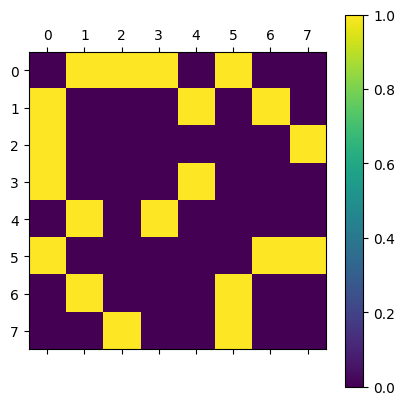

In [26]:
model = PXPModel1D(4, periodic=False)
mat = model.hamiltonian.toarray()
assert ishermitian(mat)
evals, evecs = np.linalg.eigh(mat)

plt.matshow(mat)
plt.colorbar()

In [173]:
if not model.periodic:
    if model.n % 2 == 0:
        assert np.count_nonzero(np.where(np.abs(evals) < 1e-10)[0]) == fibonacci(model.n // 2 + 1)
    else:
        assert np.count_nonzero(np.where(np.abs(evals) < 1e-10)[0]) == fibonacci(model.n // 2 - 1)

In [220]:
df = model.basis.dataframe.copy(deep=True)
df.index = format_custom_index(df.index)
df

,0,1,2,3,4,5
(0) 0,0,0,0,0,0,0
(1) 1,0,0,0,0,0,1
(2) 2,0,0,0,0,1,0
(3) 4,0,0,0,1,0,0
(4) 5,0,0,0,1,0,1
(5) 8,0,0,1,0,0,0
(6) 9,0,0,1,0,0,1
(7) 10,0,0,1,0,1,0
(8) 16,0,1,0,0,0,0
(9) 17,0,1,0,0,0,1


,0
0,-3.899993e+00
1,-2.733840e+00
2,-2.349811e+00
3,-1.961900e+00
4,-1.414214e+00
5,-1.296249e+00
6,-1.231513e+00
7,-7.669266e-01
8,-4.005531e-01
9,-5.786068e-16


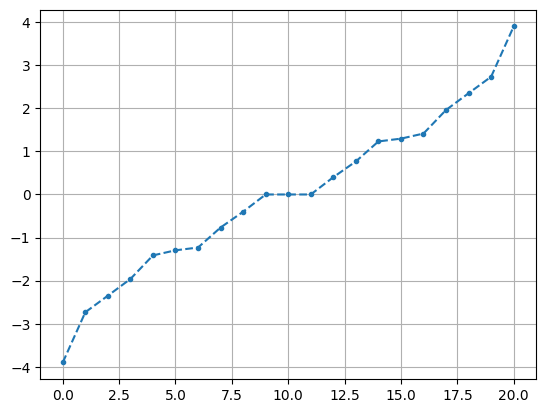

In [19]:
plt.plot(evals, linestyle="--", marker=".")
plt.grid()

pd.DataFrame(evals)

In [57]:
plt.matshow(evecs)
plt.colorbar()

array([[ 5.21608974e-01, -4.59081550e-17, -2.47502346e-01,
        -7.48594363e-02, -5.72476548e-01,  2.47502346e-01,
         2.94141727e-17,  5.21608974e-01],
       [-4.05621093e-01,  3.53553391e-01, -2.92355142e-01,
         4.95779234e-01, -6.48301735e-02, -2.92355142e-01,
         3.53553391e-01,  4.05621093e-01],
       [-2.92355142e-01, -3.53553391e-01,  4.05621093e-01,
         4.95779234e-01, -6.48301735e-02,  4.05621093e-01,
        -3.53553391e-01,  2.92355142e-01],
       [-2.92355142e-01,  3.53553391e-01,  4.05621093e-01,
        -4.95779234e-01,  6.48301735e-02,  4.05621093e-01,
         3.53553391e-01,  2.92355142e-01],
       [ 2.60804487e-01, -5.00000000e-01, -1.23751173e-01,
         7.48594363e-02,  5.72476548e-01,  1.23751173e-01,
         5.00000000e-01,  2.60804487e-01],
       [-4.05621093e-01, -3.53553391e-01, -2.92355142e-01,
        -4.95779234e-01,  6.48301735e-02, -2.92355142e-01,
        -3.53553391e-01,  4.05621093e-01],
       [ 3.03127229e-01,  1.665334

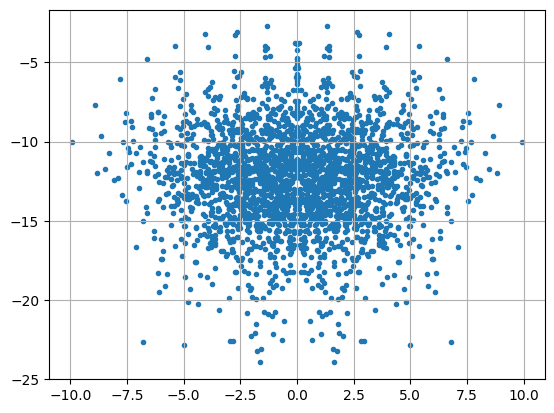

In [206]:
plt.scatter(evals, model.z2_overlap(evecs, start_with=0), marker=".")
plt.grid()

/var/folders/9z/xvqzg2q52gd8hxzhj2vgzrpm0000gn/T/ipykernel_30840/3069772978.py:3: RuntimeWarning: divide by zero encountered in log
  overlap = np.log(np.abs(zero_state[None, :] @ evecs) ** 2)


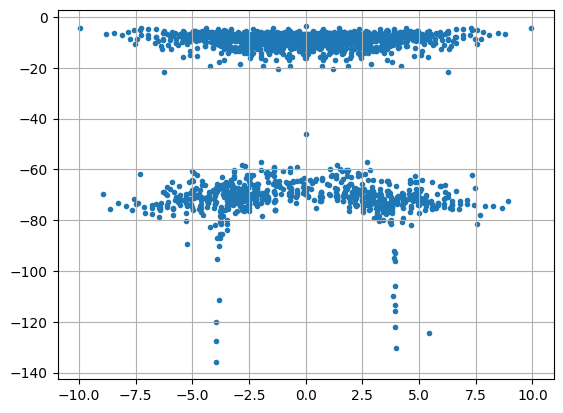

In [205]:
zero_state = np.zeros(model.basis.n_states)
zero_state[0] = 1
overlap = np.log(np.abs(zero_state[None, :] @ evecs) ** 2)
plt.scatter(evals, overlap, marker=".")
plt.grid()

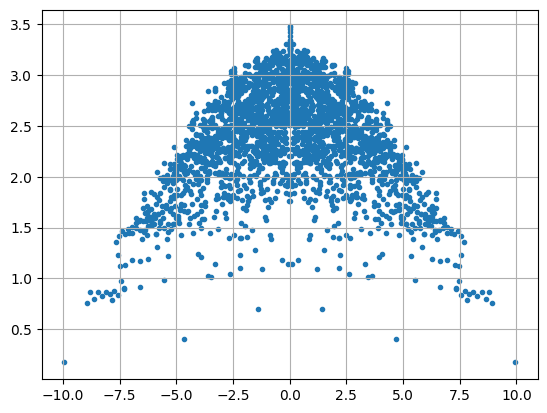

In [207]:
entropies = [model.entropy(evecs[:, i], model.n // 2 - 1) for i in range(evecs.shape[1])]
plt.scatter(evals, entropies, marker=".")
plt.grid()

In [27]:
g = nx.from_numpy_array(mat)
ig = igraph.Graph.from_networkx(g)

ntg = pynauty.Graph(
    g.number_of_nodes(),
    adjacency_dict=nx.to_dict_of_lists(g),
    # vertex_coloring=group_indices_by_value(dict(g.degree)),
)
aut_gp = pynauty.autgrp(ntg)[0]

perm_gp = PermutationGroup([Permutation(p) for p in aut_gp])
print(perm_gp.orbits())

[{0}, {1, 5}, {2, 3}, {4, 7}, {6}]
[1]


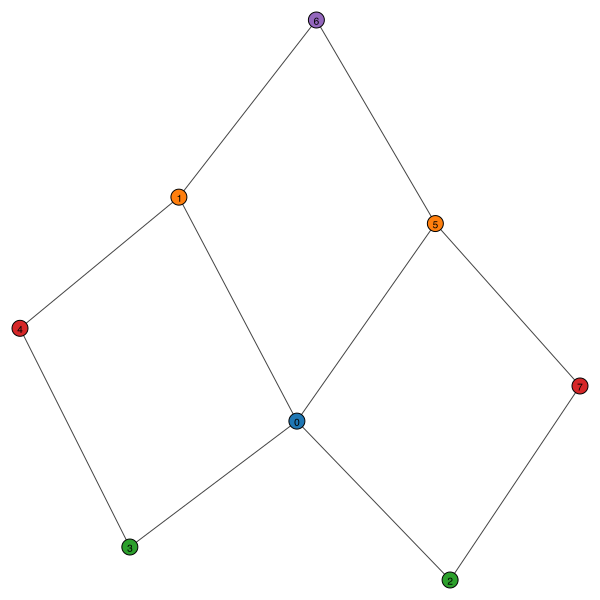

In [28]:
g = nx.from_numpy_array(mat)
assert nx.is_bipartite(g)

highlight = [
    # np.where(evecs[:, 10] > 1e-5)[0],
    # np.where(evecs[:, 10] <- 1e-5)[0],
    # np.where(np.abs(state) > 1e-5)[0],
    # [1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 18, 20]
]
highlight = perm_gp.orbits()
# highlight = list(nx.bipartite.sets(g))
# highlight_color = ["whitesmoke", "dimgray"]
# highlight_color = ["tomato", "royalblue"]
highlight_color = list(mcolors.TABLEAU_COLORS.values())
cmap = plt.get_cmap('Set2')
highlight_color += [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
cmap = plt.get_cmap('Set3')
highlight_color += [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
highlight_color *= 3

ig = setup_igraph(g, highlight, highlight_color)

# rm = np.array([6, 9, 15, 16, 17, 19])
# mask = ~np.isin(np.arange(ig.vcount()), rm)
# sub_ig = ig.induced_subgraph(np.where(np.abs(evecs[:, 13]) > 1e-5)[0])

igraph.plot(
    ig,
    # layout=ig.layout_kamada_kawai(),
    # layout=ig.layout_mds(),
    vertex_size=16,
    # edge_width=0.4,
    # edge_color="darkgray",
    vertex_label_size=10,
)

In [29]:
partition = perm_gp.orbits()
s = characteristic_matrix(partition) @ np.sqrt(np.diagflat([1/len(p) for p in partition]))
b = s.T @ nx.to_numpy_array(g) @ s

np.allclose(nx.to_numpy_array(g) @ s, s @ b, atol=1e-12)

True

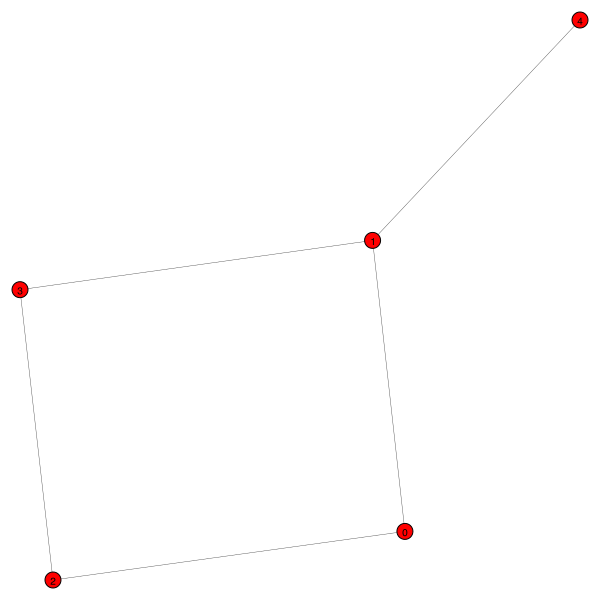

In [32]:
ig = setup_igraph(nx.from_numpy_array(b))
igraph.plot(
    ig,
    # layout=ig.layout_kamada_kawai(),
    vertex_size=16,
    edge_width=0.4,
    # edge_color="darkgray",
    vertex_label_size=10
)

In [22]:
sub_components = list(g.subgraph(c) for c in nx.connected_components(g))

for c in sub_components:
    cmat = nx.to_numpy_array(c)
    print(cmat.shape[0] - np.linalg.matrix_rank(cmat))


5


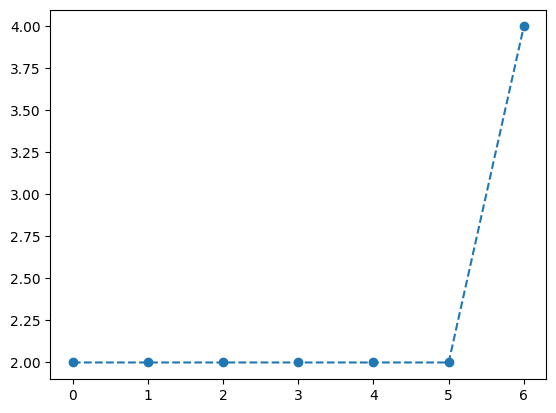

In [127]:
two_steps_mat = np.linalg.matrix_power(mat, 2)
sort_idx = np.argsort(np.diag(two_steps_mat))

plt.plot(np.diag(two_steps_mat[sort_idx, :][:, sort_idx]), linestyle="--", marker="o")
plt.show()

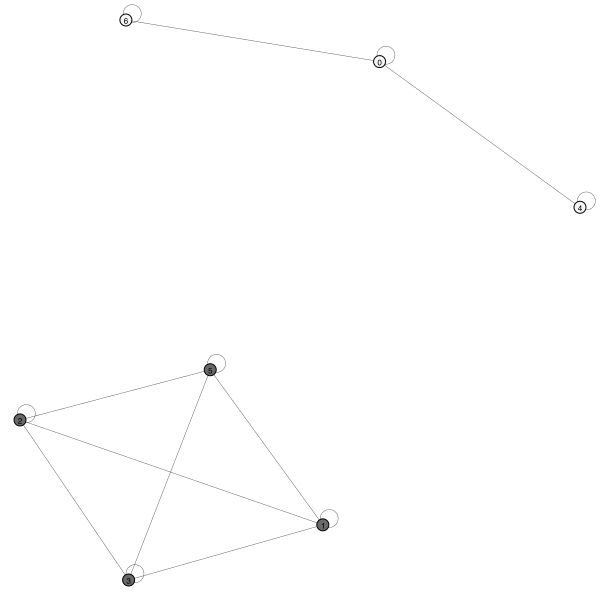

In [128]:
g = nx.from_numpy_array(two_steps_mat)
# highlight = [
# ]
# highlight_color = [
    # "aqua",
    # "deepskyblue",
    # "yellowgreen",
    # "tomato",
    # "royalblue"
# ]
ig = setup_igraph(g, highlight, highlight_color)
igraph.plot(
    ig,
    layout=ig.layout_kamada_kawai(),
    vertex_size=12,
    edge_width=0.4,
    # edge_color="darkgray",
    vertex_label_size=8
)

In [129]:
sub_components = list(g.subgraph(c) for c in nx.connected_components(g))

for c in sub_components:
    # print(nx.is_bipartite(c))
    cmat = nx.to_numpy_array(c)
    print(cmat.shape[0], cmat.shape[0] - np.linalg.matrix_rank(cmat))


3 1
4 2


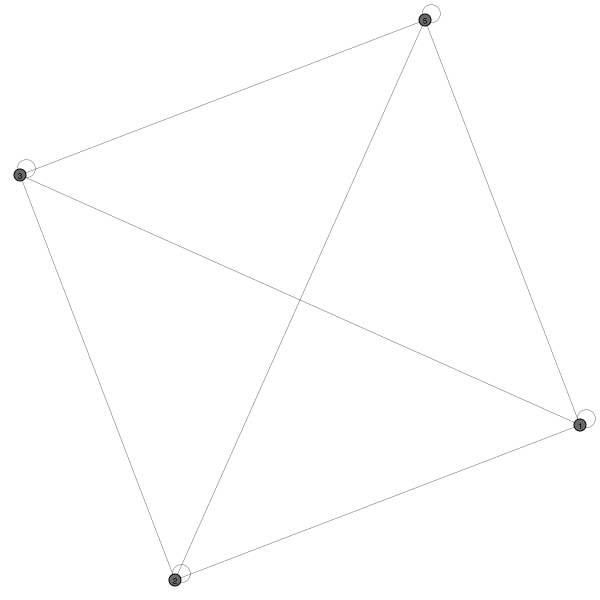

In [120]:
sub_ig = ig.subgraph(sub_components[1].nodes)
igraph.plot(
    sub_ig,
    layout=sub_ig.layout_kamada_kawai(),
    vertex_size=12,
    edge_width=0.4,
    # edge_color="darkgray",
    vertex_label_size=8
)

In [65]:
evals, evecs = np.linalg.eigh(nx.to_numpy_array(sub_components[0]))

evals

array([7.21610238e-16, 8.37722340e-01, 2.00000000e+00, 7.16227766e+00])

In [67]:
evecs.T

array([[-5.77350269e-01,  5.77350269e-01, -5.55111512e-17,
         5.77350269e-01],
       [ 3.50021175e-01,  1.75010587e-01, -9.03453245e-01,
         1.75010587e-01],
       [ 2.47397131e-16, -7.07106781e-01, -5.55111512e-17,
         7.07106781e-01],
       [-7.37666486e-01, -3.68833243e-01, -4.28686638e-01,
        -3.68833243e-01]])

In [68]:
state = np.zeros(model.basis.n_states)
state[np.array(sub_components[1].nodes)] = evecs[:, 0]

pd.DataFrame(state[:, None])

,0
0,0.000000e+00
1,-2.672612e-01
2,2.672612e-01
3,-2.672612e-01
4,0.000000e+00
5,2.672612e-01
6,0.000000e+00
7,0.000000e+00
8,-2.672612e-01
9,0.000000e+00


In [20]:
model.z2_overlap(state[:, None], start_with=0)

/Users/tandaolin/projects/qlinks/qlinks/model/pxp_model_1d.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(np.abs(z2_basis[None, :] @ evecs) ** 2)


array([[-inf]])

In [21]:
model.entropy(state, 2)

1.2739986834917572

In [69]:
sub_components[1].nodes

NodeView((1, 2, 3, 5, 8, 12, 13, 17, 19, 20))

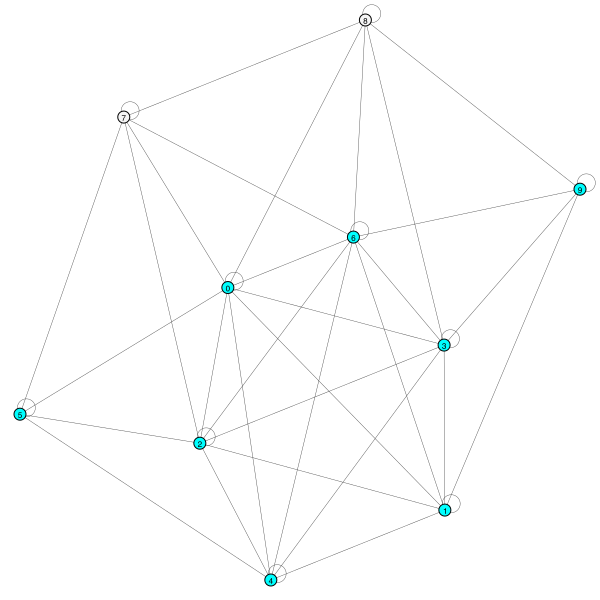

In [64]:
highlight = [
    np.where(np.abs(evecs[:, 0]) > 1e-12)[0]
]
highlight_color = [
    "aqua",
    # "deepskyblue",
    # "yellowgreen",
    # "tomato",
    # "royalblue"
]
g = nx.from_numpy_array(nx.to_numpy_array(sub_components[1]))
ig = setup_igraph(g, highlight, highlight_color)
igraph.plot(
    ig,
    layout=ig.layout_kamada_kawai(),
    # layout=ig.layout_mds(),
    vertex_size=12,
    edge_width=0.4,
    # edge_color="darkgray",
    vertex_label_size=8
)

# Ising model

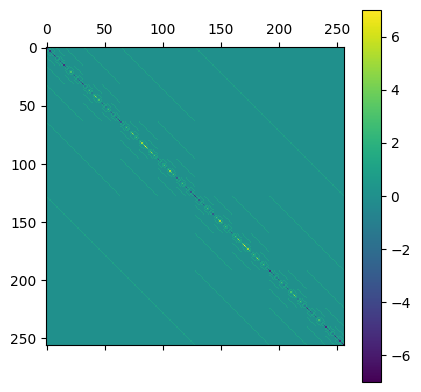

In [71]:
mat = ising_model(8, 1).toarray()
assert ishermitian(mat)

plt.matshow(mat)
plt.colorbar()

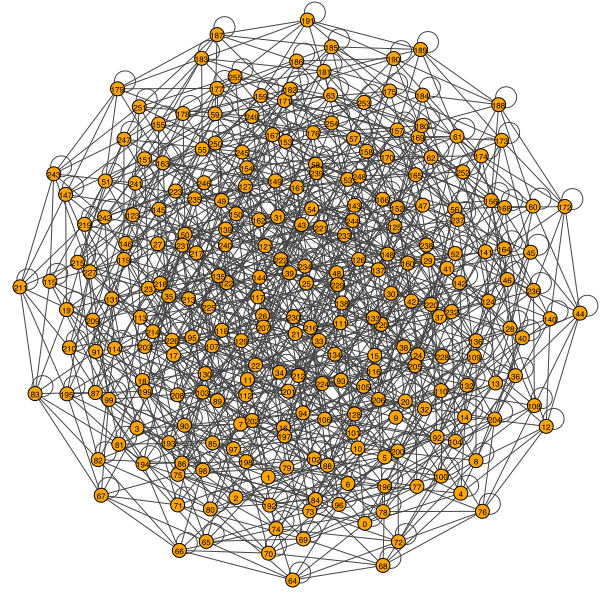

In [77]:
g = nx.from_numpy_array(mat)
ig = igraph.Graph.from_networkx(g)
ig.vs["label"] = [str(i) for i in range(ig.vcount())]
igraph.plot(
    ig,
    layout=ig.layout_kamada_kawai(),
    vertex_size=14,
    vertex_color="orange",
    # edge_width=0.4,
    # edge_color="darkgray",
    vertex_label_size=8,
)

In [15]:
import numpy as np
from scipy.linalg import eig

n = 6
A = np.random.random((n, n))
A = (A + A.T) / 2
B = np.random.random((n, n))
B = (B + B.T) / 2

In [16]:
evals, left_evecs, right_evecs = eig((B @ B @ A + B), b=B @ B, left=True, right=True)
np.real_if_close(evals)

array([ 14.26246953, -10.8217393 ,  -2.56972014,   0.94314784,
         2.34084653,   3.14140687])

In [17]:
B.T @ B.T @ left_evecs

array([[-7.32781367e-04,  1.64044896e-03, -3.20913629e-02,
         1.03019941e-01,  1.28521959e-01, -5.09032601e-03],
       [-1.18373483e-03, -1.00033890e-04,  1.14220459e-01,
        -5.97266074e-02,  5.71648887e-02, -4.11829572e-02],
       [-1.85610496e-03,  3.28852717e-03, -5.30153850e-02,
        -3.71457391e-02, -3.31280130e-02, -8.87849725e-02],
       [ 2.10529885e-03, -7.45939513e-04,  3.69357452e-02,
         1.24520788e-01, -3.88663048e-02, -7.05414779e-02],
       [ 3.16076899e-03, -8.59551106e-04, -3.78651754e-02,
        -9.98151261e-02,  6.29557642e-02, -3.75670274e-02],
       [-1.64747350e-03, -6.96508715e-03, -3.35124984e-02,
         6.56561685e-03,  1.02010402e-02, -3.03358828e-02]])

In [18]:
right_evecs

array([[-0.15441446,  0.20614906, -0.22247128,  0.50833447,  0.79008179,
        -0.03914204],
       [-0.24944107, -0.01257088,  0.79182587, -0.29471084,  0.35141806,
        -0.31667614],
       [-0.39112545,  0.41325685, -0.3675257 , -0.18328937, -0.20365267,
        -0.68271159],
       [ 0.44363652, -0.09373942,  0.25605464,  0.61442676, -0.23892851,
        -0.54242834],
       [ 0.66604918, -0.10801656, -0.26249786, -0.49252085,  0.38701715,
        -0.28887147],
       [-0.34716184, -0.87527633, -0.23232321,  0.03239693,  0.06271034,
        -0.23326762]])

In [19]:
np.real_if_close(left_evecs.T @ B @ B @ right_evecs)

array([[ 4.74554898e-03, -9.76309034e-18,  6.98786880e-17,
        -2.31805091e-16,  9.15497150e-16, -1.04099135e-15],
       [ 1.05562326e-17,  7.95758653e-03, -1.08322339e-16,
         1.32749476e-16,  5.60259852e-17, -2.04373930e-16],
       [-6.50152900e-17,  1.55408876e-17,  1.44249465e-01,
        -1.72445906e-16,  2.65667241e-16, -3.60350296e-16],
       [-5.31575115e-17,  2.46498625e-17, -2.24901177e-16,
         2.02661726e-01, -4.80477574e-16,  5.43488558e-16],
       [ 3.04294677e-16,  7.89100354e-17, -3.99095740e-16,
         5.28713423e-16,  1.62669182e-01, -7.27624554e-16],
       [ 1.70718129e-17,  1.06921212e-16, -2.61843800e-16,
         4.97130610e-16, -1.67560150e-16,  1.30047553e-01]])

In [20]:
evals, left_evecs, right_evecs = eig(A + np.linalg.pinv(B), left=True, right=True)
np.real_if_close(evals)

array([ 14.26246953, -10.8217393 ,  -2.56972014,   0.94314784,
         2.34084653,   3.14140687])

In [21]:
right_evecs

array([[ 0.15441446,  0.20614906, -0.22247128, -0.50833447, -0.79008179,
         0.03914204],
       [ 0.24944107, -0.01257088,  0.79182587,  0.29471084, -0.35141806,
         0.31667614],
       [ 0.39112545,  0.41325685, -0.3675257 ,  0.18328937,  0.20365267,
         0.68271159],
       [-0.44363652, -0.09373942,  0.25605464, -0.61442676,  0.23892851,
         0.54242834],
       [-0.66604918, -0.10801656, -0.26249786,  0.49252085, -0.38701715,
         0.28887147],
       [ 0.34716184, -0.87527633, -0.23232321, -0.03239693, -0.06271034,
         0.23326762]])

In [22]:
left_evecs

array([[ 0.15441446,  0.20614906, -0.22247128, -0.50833447, -0.79008179,
         0.03914204],
       [ 0.24944107, -0.01257088,  0.79182587,  0.29471084, -0.35141806,
         0.31667614],
       [ 0.39112545,  0.41325685, -0.3675257 ,  0.18328937,  0.20365267,
         0.68271159],
       [-0.44363652, -0.09373942,  0.25605464, -0.61442676,  0.23892851,
         0.54242834],
       [-0.66604918, -0.10801656, -0.26249786,  0.49252085, -0.38701715,
         0.28887147],
       [ 0.34716184, -0.87527633, -0.23232321, -0.03239693, -0.06271034,
         0.23326762]])

# MPS exact scars in PXP

In [ ]:
import quimb.tensor as qtn


b_mat = np.array(
    [
        [[1, 0], [0, 0], [0, 0]],
        [[0, np.sqrt(2)], [1, 0], [0, np.sqrt(2)]]
    ]
)

c_mat = np.array(
    [
        [[0, np.sqrt(2)], [-1, 0]],
        [[1, 0], [0, 0]],
        [[0, -np.sqrt(2)], [0, 0]]
    ]
)

vec1 = np.array([1, 1])
vec2 = np.array([1, -1])

def obc_mps(n, idx_a, idx_b):
    mps = [b_mat, c_mat] * (n // 2)
    left_vec = {
        0: vec1,
        1: vec2
    }[idx_a]
    right_vec = {
        0: vec1,
        1: vec2
    }[idx_b]
    mps[0] = np.einsum("i,ijk->jk", left_vec, mps[0])
    mps[-1] = np.einsum("ijk,j->ik", mps[-1], right_vec)
    return qtn.MatrixProductState(mps)

mps = obc_mps(6, 0, 1).to_dense()
# mps /= np.linalg.norm(mps)
idx = model.basis.index.astype(int)
mps.T[:, idx]

In [77]:
{i: j for i, j in enumerate(product([0, 1], repeat=4))}

{0: (0, 0, 0, 0),
 1: (0, 0, 0, 1),
 2: (0, 0, 1, 0),
 3: (0, 0, 1, 1),
 4: (0, 1, 0, 0),
 5: (0, 1, 0, 1),
 6: (0, 1, 1, 0),
 7: (0, 1, 1, 1),
 8: (1, 0, 0, 0),
 9: (1, 0, 0, 1),
 10: (1, 0, 1, 0),
 11: (1, 0, 1, 1),
 12: (1, 1, 0, 0),
 13: (1, 1, 0, 1),
 14: (1, 1, 1, 0),
 15: (1, 1, 1, 1)}